In [5]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Queretaro hexagons

In [6]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


<Axes: >

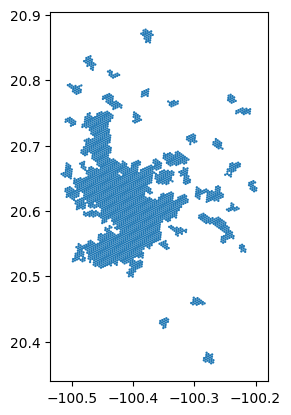

In [7]:
hex_gdf.plot()

### Nodes, edges

In [4]:
hex_gdf = hex_gdf.set_crs("EPSG:4326")

G,nodes,edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_speed_23_line', nodes_folder='nodes_osmnx_23_point')

## Access to job analysis

In [5]:
from tqdm import tqdm

In [6]:
tqdm.pandas()

Create isochrone by node

In [7]:
folder_denue = 'denue'
table_denue = 'denue_23_point'

osmid_isochrone = {}

nodes_job = nodes.reset_index()[['osmid','geometry']].copy()

In [9]:
nodes_job['iso_geom'] = nodes_job.progress_apply(lambda row: aup.calculate_isochrone(G, row.loc['osmid'], 30, dist_column='time_min'), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77203/77203 [123:27:08<00:00,  5.76s/it]


In [18]:
nodes_job.head(2)

,osmid,geometry
0,30880912,"POLYGON ((-100.25023 20.55497, -100.25977 20.5..."
1,409445514,"POLYGON ((-100.32348 20.56309, -100.32719 20.5..."


In [16]:
# nodes_job = nodes_job.drop(columns=['geometry'])
# nodes_job = nodes_job.rename(columns={'iso_geom':'geometry'})
# nodes_job = gpd.GeoDataFrame(nodes_job, geometry='geometry')
nodes_job = nodes_job.set_crs("EPSG:4326")

<Axes: >

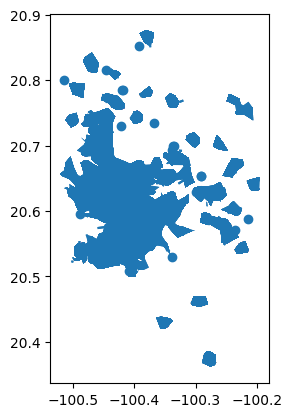

In [19]:
nodes_job.plot()

Download DENUE

In [20]:
gdf_tmp = nodes_job.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [22]:
folder_denue = 'denue'
table_denue = 'denue_23_point'

# download denue
query = f"SELECT * FROM {folder_denue}.{table_denue} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

denue = aup.gdf_from_query(query, geometry_col='geometry')

print(denue.shape)
denue.head(4)

(61999, 43)


,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta,geometry
0,8283105.0,22014332320006711000000000U2,HERRERIA EN CASA,None,332320,Fabricación de productos de herrería,0 a 5 personas,PRIVADA,BENITO JUAREZ,PRIVADA,...,1602,18.0,4423787031,None,None,Fijo,20.761568,-100.427826,2019-11,POINT (-100.42783 20.76157)
1,8283203.0,22014312112001071000000000U1,AGUA PURIFICADOR SANTA ROSA,None,312112,Purificación y embotellado de agua,0 a 5 personas,CALLE,HACIENDA VISTA HERMOSA,CALLE,...,4310,40.0,4422696820,SANTAROSAA14@YAHOO.COM.MX,None,Fijo,20.765076,-100.436680,2019-11,POINT (-100.43668 20.76508)
2,3606748.0,22014332510000023000000000U4,RAPIDEZ Y PRECISION EN MAQUINADOS,RAPIDEZ Y PRECISION EN MAQUINADOS SA DE CV,332510,Fabricación de herrajes y cerraduras,11 a 30 personas,CALLE,IGNACIO ZARAGOZA,CALLE,...,1602,28.0,None,RPM_OF@YAHOO.COM.MX,None,Fijo,20.761156,-100.435850,2010-07,POINT (-100.43585 20.76116)
3,8793668.0,22014311830006951000000000U7,HERMANOS VEGA TORTILLERIA,None,311830,Elaboración de tortillas de maíz y molienda de...,0 a 5 personas,CALLE,MIGUEL HIDALGO,CALLE,...,1602,7.0,4422052760,None,None,Fijo,20.760954,-100.429220,2019-11,POINT (-100.42922 20.76095)


Access to jobs

In [23]:
def clip_denue(denue, geom, denue_size_dict):
    # clip denue into gdf
    denue_clip = gpd.clip(denue, geom)
        
    # jobs data to nodes
    total_denue = denue_clip.shape[0]
    total_jobs = denue_clip.per_ocu_num.sum()
    
    job_dict = {}
    denue_size_list = []

    for denue_size in denue_size_dict.keys():
        denue_size_list.append(denue_size)
        job_dict[denue_size] = denue_clip.loc[denue_clip.per_ocu==denue_size_dict[denue_size]].shape[0]
    
    return (total_denue, total_jobs, job_dict[denue_size_list[0]],
            job_dict[denue_size_list[1]], job_dict[denue_size_list[2]],
            job_dict[denue_size_list[3]], job_dict[denue_size_list[4]],
            job_dict[denue_size_list[5]], job_dict[denue_size_list[6]])

In [24]:
denue_size_dict = {'denue_0_5':'0 a 5 personas',
                'denue_6_10':'6 a 10 personas',
                'denue_11_30':'11 a 30 personas',
                'denue_31_50':'31 a 50 personas',
                'denue_51_100':'51 a 100 personas',
                'denue_101_250':'101 a 250 personas',
                'denue_250_mas':'251 y más personas'}

In [25]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [26]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [28]:
# calculate jobs
job_analysis_columns = ['denue_count','denue_jobs','denue_0_5','denue_6_10',
                    'denue_11_30','denue_31_50','denue_51_100',
                    'denue_101_250','denue_250_mas']

for i in tqdm(range(len(nodes_job)), position=0, leave=True):
    
    osmid = nodes_job.iloc[i].osmid
    geom = nodes_job.iloc[i].geometry
    
    if geom.geom_type=='Point' or geom.geom_type=='LineString':
        continue

    # create isochrone
    nodes_job.loc[nodes_job.osmid==osmid, job_analysis_columns] = clip_denue(denue, geom, denue_size_dict)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77203/77203 [14:56<00:00, 86.15it/s]


In [29]:
nodes_job_data = nodes.merge(nodes_job.drop(columns=['geometry']), on='osmid', how='left')
print(nodes_job_data.shape)
nodes_job_data.head(4)

(77203, 15)


,osmid,x,y,street_count,geometry,city,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas
0,30880912,-100.251490,20.568287,3,POINT (-100.25149 20.56829),Queretaro,417.0,7536.0,334.0,18.0,27.0,10.0,8.0,11.0,9.0
1,409445514,-100.318224,20.572132,3,POINT (-100.31822 20.57213),Queretaro,301.0,2891.0,224.0,33.0,25.0,12.0,4.0,2.0,1.0
2,409445518,-100.316625,20.571697,3,POINT (-100.31663 20.5717),Queretaro,229.0,1820.0,183.0,22.0,16.0,5.0,1.0,1.0,1.0
3,412201229,-100.343800,20.591755,3,POINT (-100.3438 20.59175),Queretaro,282.0,2322.0,201.0,43.0,31.0,2.0,2.0,3.0,0.0


In [32]:
nodes_job_data = nodes_job_data.drop(columns=['x','y','street_count','city'])

In [34]:
hex_gdf

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban
2,894983d88bbffff,"POLYGON ((-100.43124 20.55215, -100.42999 20.5...",22006,Corregidora,Queretaro,urban
3,894983c1687ffff,"POLYGON ((-100.44908 20.58645, -100.44784 20.5...",22006,Corregidora,Queretaro,urban
4,894983d8c13ffff,"POLYGON ((-100.42791 20.52785, -100.42667 20.5...",22006,Corregidora,Queretaro,urban
...,...,...,...,...,...,...
2821,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615...",22014,Querétaro,Queretaro,urban
2822,894983d8b37ffff,"POLYGON ((-100.43042 20.58459, -100.42918 20.5...",22014,Querétaro,Queretaro,urban
2823,894983cd843ffff,"POLYGON ((-100.47042 20.8249, -100.46917 20.82...",22014,Querétaro,Queretaro,urban
2824,894983ca0c7ffff,"POLYGON ((-100.39311 20.60654, -100.39187 20.6...",22014,Querétaro,Queretaro,urban


In [39]:
nodes_job_data

,osmid,geometry,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas
0,30880912,POINT (-100.25149 20.56829),417.0,7536.0,334.0,18.0,27.0,10.0,8.0,11.0,9.0
1,409445514,POINT (-100.31822 20.57213),301.0,2891.0,224.0,33.0,25.0,12.0,4.0,2.0,1.0
2,409445518,POINT (-100.31663 20.5717),229.0,1820.0,183.0,22.0,16.0,5.0,1.0,1.0,1.0
3,412201229,POINT (-100.3438 20.59175),282.0,2322.0,201.0,43.0,31.0,2.0,2.0,3.0,0.0
4,412203726,POINT (-100.35794 20.59405),434.0,3765.0,328.0,62.0,32.0,3.0,2.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
77198,3013347760,POINT (-100.45526 20.72686),8.0,130.0,5.0,0.0,2.0,0.0,1.0,0.0,0.0
77199,3013347762,POINT (-100.45622 20.72702),7.0,110.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0
77200,3013347765,POINT (-100.45748 20.72729),10.0,146.0,5.0,2.0,2.0,0.0,1.0,0.0,0.0
77201,3013347767,POINT (-100.4545 20.72742),25.0,191.0,20.0,2.0,2.0,0.0,1.0,0.0,0.0


Node data to hex

In [41]:
hex_gdf

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban
2,894983d88bbffff,"POLYGON ((-100.43124 20.55215, -100.42999 20.5...",22006,Corregidora,Queretaro,urban
3,894983c1687ffff,"POLYGON ((-100.44908 20.58645, -100.44784 20.5...",22006,Corregidora,Queretaro,urban
4,894983d8c13ffff,"POLYGON ((-100.42791 20.52785, -100.42667 20.5...",22006,Corregidora,Queretaro,urban
...,...,...,...,...,...,...
2821,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615...",22014,Querétaro,Queretaro,urban
2822,894983d8b37ffff,"POLYGON ((-100.43042 20.58459, -100.42918 20.5...",22014,Querétaro,Queretaro,urban
2823,894983cd843ffff,"POLYGON ((-100.47042 20.8249, -100.46917 20.82...",22014,Querétaro,Queretaro,urban
2824,894983ca0c7ffff,"POLYGON ((-100.39311 20.60654, -100.39187 20.6...",22014,Querétaro,Queretaro,urban


In [42]:
hex_job = aup.group_by_hex_mean(nodes_job_data, hex_gdf[['hex_id_9','geometry']], job_analysis_columns, 
                               hex_id_col='hex_id_9')
print(hex_job.shape)
hex_job.head(4)

(2826, 11)


,hex_id_9,geometry,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas
686,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566,89498224107ffff,"POLYGON ((-100.22715 20.75245, -100.2259 20.75...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,8949822410bffff,"POLYGON ((-100.22092 20.75182, -100.21968 20.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Economical unit size

In [43]:
hex_job['denue_jobs_>_11'] = hex_job['denue_jobs'] - hex_job['denue_0_5'] * 3 - hex_job['denue_6_10'] * 8
hex_job['pct_jobs_>_11'] = hex_job['denue_jobs_>_11'] / hex_job['denue_jobs']

In [44]:
hex_job.to_file('../../../data/processed/hex_denue.geojson')

## Proximity to tianguis

In [8]:
tianguis_gdf = gpd.read_file('../data/processed/tianguis_point.shp')
tianguis_gdf = tianguis_gdf.to_crs("EPSG:4326")
print(tianguis_gdf.shape)
tianguis_gdf.head(2)

(20742, 13)


,fid,cat,Nombre_del,Tipo,Nombre_de0,Longitud__,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,1,GUADALAJARA,REGULAR,MELCHOR MUZQUIZ,181.46,0,0,0,0,0.00000,212.66563,POINT (-103.31883 20.65242)
1,1.0,1,GUADALAJARA,REGULAR,MELCHOR MUZQUIZ,181.46,-1,1,0,1,9.55078,212.66563,POINT (-103.31888 20.65235)


In [10]:
tianguis_osmid = proylib.find_nearest(G, nodes, tianguis_gdf, return_distance= True)
nodes_tianguis = proylib.calculate_distance_nearest_poi(tianguis_osmid, nodes, 
                                       edges, 'tianguis', 'osmid', wght='time_min')
nodes_tianguis = nodes_tianguis.reset_index()
nodes_tianguis.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_tianguis
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),2.523255
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),5.730982
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),1.394160
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),0.000000


In [14]:
nodes_tianguis = nodes_tianguis.to_crs("EPSG:32613")
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_eco = proylib.group_by_hex_mean(nodes_tianguis, hex_gdf, 9, 'dist_tianguis')
print(hex_eco.shape)
hex_eco.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_tianguis
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,13.406640
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,10.794146


<AxesSubplot: >

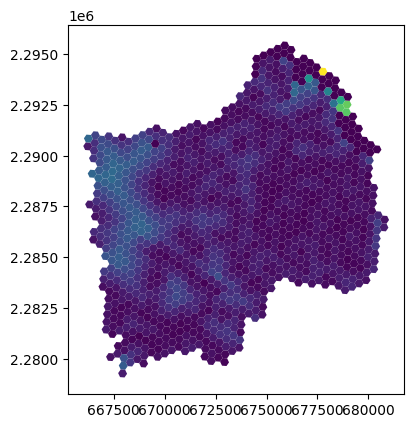

In [15]:
hex_eco.plot('dist_tianguis')

## Proximity to mercados

In [20]:
mercados_gdf = gpd.read_file('../data/processed/mercados_amg.geojson')
mercados_gdf = mercados_gdf.to_crs("EPSG:4326")
print(mercados_gdf.shape)
mercados_gdf.head(2)

(179, 4)


,Nombre_del,Nombre_de0,Categor�a_,geometry
0,GUADALAJARA,REFORMA (FEDERACI�N),TERCERA CATEGOR�A,POINT (-103.33566 20.67907)
1,GUADALAJARA,PASAJE MORELOS,PRIMERA CATEGOR�A,POINT (-103.34787 20.67695)


In [21]:
mercados_osmid = proylib.find_nearest(G, nodes, mercados_gdf, return_distance= True)
nodes_mercado = proylib.calculate_distance_nearest_poi(mercados_osmid, nodes, 
                                       edges, 'mercado', 'osmid', wght='time_min')
nodes_mercado = nodes_mercado.reset_index()
nodes_mercado.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_mercado
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),9.637074
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),10.080722
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),11.240130
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),12.160329


In [26]:
nodes_mercado = nodes_mercado.to_crs("EPSG:32613")
hex_mercado = proylib.group_by_hex_mean(nodes_mercado, hex_gdf, 9, 'dist_mercado')
print(hex_mercado.shape)
hex_mercado.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_mercado
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,20.115345
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,11.302824


## Merge hexagon data

In [27]:
hex_eco = hex_eco.merge(hex_mercado[['hex_id_9','dist_mercado']],
                       on='hex_id_9', how='outer')
hex_eco.head(2)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_tianguis,dist_mercado
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,13.406640,20.115345
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,10.794146,11.302824


In [29]:
hex_denue = gpd.read_file('../data/processed/hex_denue.geojson')
hex_denue.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,geometry
0,89498c94383ffff,14039,Guadalajara,Guadalajara,urban,4050.800000,20316.800000,3570.650000,249.200000,183.20000,25.400000,13.55000,6.300000,2.500000,7611.250000,0.374628,"POLYGON ((-103.31114 20.70199, -103.30992 20.7..."
1,89498c96e0bffff,14039,Guadalajara,Guadalajara,urban,11895.862069,116252.344828,8842.137931,1547.896552,1013.12069,194.810345,139.87931,83.724138,74.293103,77342.758621,0.665301,"POLYGON ((-103.35267 20.66765, -103.35145 20.6..."


In [31]:
hex_eco = hex_eco.merge(hex_denue[['hex_id_9','denue_count',
                        'denue_jobs','denue_0_5',
                        'denue_6_10','denue_11_30',
                        'denue_31_50','denue_51_100',
                        'denue_101_250','denue_250_mas',
                        'denue_jobs_>_11','pct_jobs_>_11']],
             on='hex_id_9', how='outer')
print(hex_eco.shape)
hex_eco.head(2)

(1214, 24)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,...,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,...,35226.176471,1576.411765,393.000000,310.294118,68.529412,60.411765,35.588235,23.529412,27352.941176,0.776495
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,...,116252.344828,8842.137931,1547.896552,1013.120690,194.810345,139.879310,83.724138,74.293103,77342.758621,0.665301


In [32]:
hex_eco.to_file('../data/processed/hex_economic.geojson')

## Integrate Economic type data

In [20]:
hex_eco = gpd.read_file('../../../data/processed/Distrito_QRO/hex_economic.geojson')
print(hex_eco.shape)
hex_eco.head(2)

(2826, 13)


,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,geometry
0,8949822402fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


In [21]:
folder_denue = 'denue'
table_denue = 'denue_23_point'

In [22]:
gdf_tmp = hex_eco.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [23]:
# download denue
query = f"SELECT * FROM {folder_denue}.{table_denue} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

denue = aup.gdf_from_query(query, geometry_col='geometry')

In [24]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [25]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [26]:
denue['per_ocu_num'].unique()

array([  3,  20,   8,  40,  75, 175, 325])

In [27]:
denue['codigo_grl'] = denue.codigo_act.apply(lambda x: x[:-4])

In [28]:
denue.codigo_grl.unique()

array(['33', '31', '46', '54', '71', '72', '81', '53', '56', '61', '62',
       '93', '23', '32', '21', '43', '52', '48', '51', '49', '55', '11',
       '22'], dtype=object)

In [29]:
len(denue.codigo_grl.unique())

23

In [30]:
clas_act = {'Industria':['31','32','33'],
           'Comercio':['43','46'],
           'Servicios':['52','53','54','55','56',
                       '61','62','71','72','81'],
           'Otros':['11','21','22','23',
                    '51','48','49',],
           'Gubernamental':['93']}

In [31]:
act_name = {}
for k,v in clas_act.items():
    for x in v:
        act_name.setdefault(x, []).append(k)

In [32]:
act_name

{'31': ['Industria'],
 '32': ['Industria'],
 '33': ['Industria'],
 '43': ['Comercio'],
 '46': ['Comercio'],
 '52': ['Servicios'],
 '53': ['Servicios'],
 '54': ['Servicios'],
 '55': ['Servicios'],
 '56': ['Servicios'],
 '61': ['Servicios'],
 '62': ['Servicios'],
 '71': ['Servicios'],
 '72': ['Servicios'],
 '81': ['Servicios'],
 '11': ['Otros'],
 '21': ['Otros'],
 '22': ['Otros'],
 '23': ['Otros'],
 '51': ['Otros'],
 '48': ['Otros'],
 '49': ['Otros'],
 '93': ['Gubernamental']}

In [33]:
denue['nombre_act'] = denue.codigo_grl.apply(lambda x: act_name[x][0])

In [34]:
denue['nombre_act'].unique()

array(['Industria', 'Comercio', 'Servicios', 'Gubernamental', 'Otros'],
      dtype=object)

### Hex DENUE

In [35]:
hex_denue = denue.overlay(hex_eco[['hex_id_9','geometry']])
hex_denue = hex_denue.groupby(['hex_id_9','nombre_act']).sum(numeric_only=True)
hex_denue = hex_denue.reset_index()
hex_denue = hex_denue[['hex_id_9','nombre_act','per_ocu_num']].copy()
hex_denue

,hex_id_9,nombre_act,per_ocu_num
0,89498224c0bffff,Servicios,3
1,89498224c47ffff,Comercio,9
2,89498224c47ffff,Industria,3
3,89498224c47ffff,Servicios,26
4,89498224c4bffff,Servicios,3
...,...,...,...
4909,894983db473ffff,Comercio,6
4910,894983db473ffff,Industria,3
4911,894983db473ffff,Servicios,3
4912,894983db47bffff,Comercio,8


In [36]:
hex_denue = hex_denue.set_index(['hex_id_9']).pivot(columns=['nombre_act'])
hex_denue.columns = hex_denue.columns.droplevel()
hex_denue = hex_denue.reset_index()
hex_denue = hex_denue.fillna(0)
hex_denue['per_ocu_tot'] = hex_denue['Comercio'] + hex_denue['Gubernamental'] + hex_denue['Industria'] + hex_denue['Servicios'] + hex_denue['Otros']
hex_denue

nombre_act,hex_id_9,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot
0,89498224c0bffff,0.0,0.0,0.0,0.0,3.0,3.0
1,89498224c47ffff,9.0,0.0,3.0,0.0,26.0,38.0
2,89498224c4bffff,0.0,0.0,0.0,0.0,3.0,3.0
3,89498224c4fffff,39.0,0.0,3.0,0.0,18.0,60.0
4,89498224c63ffff,48.0,0.0,6.0,0.0,40.0,94.0
...,...,...,...,...,...,...,...
1734,894983db447ffff,35.0,0.0,3.0,0.0,6.0,44.0
1735,894983db44fffff,3.0,0.0,0.0,0.0,0.0,3.0
1736,894983db457ffff,6.0,0.0,0.0,0.0,3.0,9.0
1737,894983db473ffff,6.0,0.0,3.0,0.0,3.0,12.0


In [37]:
hex_eco = hex_eco.merge(hex_denue, on='hex_id_9', how='left')
hex_eco

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,geometry,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot
0,8949822402fffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.2089 20.74718, -100.20765 20.74...",NaN,NaN,NaN,NaN,NaN,NaN
1,89498224103ffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.22424 20.75045, -100.223 20.752...",NaN,NaN,NaN,NaN,NaN,NaN
2,89498224107ffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.22715 20.75245, -100.2259 20.75...",NaN,NaN,NaN,NaN,NaN,NaN
3,8949822410bffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.22092 20.75182, -100.21968 20.7...",NaN,NaN,NaN,NaN,NaN,NaN
4,8949822410fffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.22383 20.75383, -100.22258 20.7...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,894983db47bffff,92.000000,381.000000,83.000000,4.000000,5.0,0.0,0.0,0.0,0.0,100.0,0.262467,"POLYGON ((-100.34505 20.434, -100.34381 20.435...",8.0,0.0,0.0,0.0,11.0,19.0
2822,894983db4c3ffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-100.34671 20.42048, -100.34547 20.4...",NaN,NaN,NaN,NaN,NaN,NaN
2823,894983db4c7ffff,92.000000,381.000000,83.000000,4.000000,5.0,0.0,0.0,0.0,0.0,100.0,0.262467,"POLYGON ((-100.34961 20.42248, -100.34837 20.4...",NaN,NaN,NaN,NaN,NaN,NaN
2824,894983db4cfffff,91.714286,379.428571,82.857143,3.857143,5.0,0.0,0.0,0.0,0.0,100.0,0.263554,"POLYGON ((-100.3463 20.42386, -100.34505 20.42...",NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
hex_eco = hex_eco.fillna(0)

In [39]:
tipo_act = ['Comercio','Industria','Gubernamental',
           'Servicios','Otros']
for act in tipo_act:
    hex_eco.loc[:,[act]] = hex_eco[act] / hex_eco['per_ocu_tot']

<Axes: >

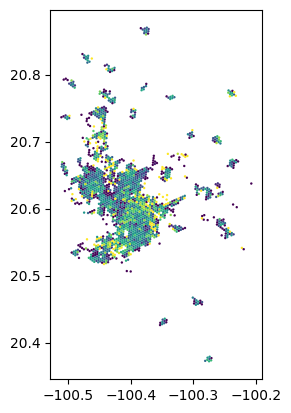

In [42]:
hex_eco.plot('Servicios')

In [43]:
hex_eco.to_file('../../../data/processed/Distrito_QRO/hex_economic.geojson')